In [ ]:
!pip install rank_bm25

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

# **Keyword Matching + BERT Retrieval**

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("newspop")

# Extract headlines and topics
headlines = dataset["train"]["headline"]  # Corpus
topics = dataset["train"]["topic"]

# Simulate queries based on unique topics
unique_topics = list(set(topics))  # Get all unique topics
queries = [f"What are the latest news about {topic}?" for topic in unique_topics]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the corpus (headlines)
corpus_vectors = vectorizer.fit_transform(headlines)

# Transform queries into the same TF-IDF space
query_vectors = vectorizer.transform(queries)

# Compute cosine similarity between queries and headlines
tfidf_scores = (query_vectors @ corpus_vectors.T).toarray()  # Shape: (num_queries, num_headlines)

# Rank headlines by similarity for each query
tfidf_ranked_indices = tfidf_scores.argsort(axis=1)[:, ::-1]  # Sort indices in descending order of similarity

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = BertModel.from_pretrained("distilbert/distilbert-base-uncased")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to encode text in batches
def batch_encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token embedding
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)  # Combine all batch embeddings into a single array

# Encode queries and headlines in batches
query_embeddings = batch_encode(queries, batch_size=32)  # Shape: (num_queries, embedding_dim)
headline_embeddings = batch_encode(headlines, batch_size=32)  # Shape: (num_headlines, embedding_dim)

In [ ]:
# Convert embeddings to NumPy arrays
query_embeddings = np.array(query_embeddings)
headline_embeddings = np.array(headline_embeddings)

In [ ]:
# Compute cosine similarity in batches
def batch_cosine_similarity(query_embeddings, headline_embeddings, batch_size=100):
    scores = []
    for i in range(0, len(query_embeddings), batch_size):
        query_batch = query_embeddings[i:i + batch_size]
        batch_scores = np.dot(query_batch, headline_embeddings.T)  # Dot product for cosine similarity
        scores.append(batch_scores)
    return np.vstack(scores)  # Combine all batch scores into a single array

# Compute similarity scores
bert_scores = batch_cosine_similarity(query_embeddings, headline_embeddings, batch_size=100)
# Rank headlines by similarity for each query
bert_ranked_indices = bert_scores.argsort(axis=1)[:, ::-1]  # Sort indices in descending order of similarity

In [ ]:
# Combine scores (e.g., weighted average)
alpha = 0.5  # Weight for TF-IDF scores
combined_scores = alpha * tfidf_scores + (1 - alpha) * bert_scores

# Rank headlines by combined scores
combined_ranked_indices = combined_scores.argsort(axis=1)[:, ::-1]  # Sort indices in descending order of combined scores

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create true indices for evaluation
true_indices = []
for query_topic in unique_topics:
    relevant_indices = [i for i, topic in enumerate(topics) if topic == query_topic]
    true_indices.append(relevant_indices)

# Evaluate retrieval performance
import numpy as np
import time
import psutil  # For memory usage monitoring

def evaluate(retrieved_indices, true_indices, top_k=5):
    precisions, recalls, f1s, mrr_scores, ndcg_scores = [], [], [], [], []
    total_inference_time = 0
    peak_memory_usage = 0

    for retrieved, true in zip(retrieved_indices, true_indices):
        # Convert true and retrieved indices to sets for easier comparison
        true_set = set(true)
        retrieved_top_k = retrieved[:top_k]  # Consider only top-k results
        retrieved_set = set(retrieved_top_k)

        # Compute Precision, Recall, and F1-Score
        precision = len(retrieved_set.intersection(true_set)) / len(retrieved_set) if retrieved_set else 0
        recall = len(retrieved_set.intersection(true_set)) / len(true_set) if true_set else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Compute Mean Reciprocal Rank (MRR)
        rank_of_first_relevant = next((i + 1 for i, idx in enumerate(retrieved) if idx in true_set), None)
        mrr = 1 / rank_of_first_relevant if rank_of_first_relevant else 0

        # Compute Normalized Discounted Cumulative Gain (nDCG)
        dcg = sum(
            (1 / np.log2(i + 2) if retrieved[i] in true_set else 0)
            for i in range(min(len(retrieved), top_k))
        )
        idcg = sum(
            (1 / np.log2(i + 2) for i in range(min(len(true_set), top_k)))
        )
        ndcg = dcg / idcg if idcg > 0 else 0

        # Append scores to lists
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        mrr_scores.append(mrr)
        ndcg_scores.append(ndcg)

    # Measure Inference Time and Memory Usage
    start_time = time.time()
    process = psutil.Process()
    peak_memory_usage = process.memory_info().rss / (1024 ** 2)  # Memory usage in MB
    total_inference_time = time.time() - start_time

    # Aggregate Results
    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "MRR": np.mean(mrr_scores),
        "nDCG": np.mean(ndcg_scores),
        "Inference Time (seconds)": total_inference_time,
        "Peak Memory Usage (MB)": peak_memory_usage
    }

# Evaluate all methods
print("TF-IDF Evaluation:", evaluate(tfidf_ranked_indices, true_indices, top_k=5))
print("BERT Evaluation:", evaluate(bert_ranked_indices, true_indices, top_k=5))
print("Combined Evaluation:", evaluate(combined_ranked_indices, true_indices, top_k=5))

TF-IDF Evaluation: {'Precision': 0.5, 'Recall': 0.00013720449112479733, 'F1-Score': 0.0002743115248327779}
BERT Evaluation: {'Precision': 0.44999999999999996, 'Recall': 7.98933091042696e-05, 'F1-Score': 0.00015975701273398092}
Combined Evaluation: {'Precision': 0.44999999999999996, 'Recall': 7.98933091042696e-05, 'F1-Score': 0.00015975701273398092}


# Plotting graphs

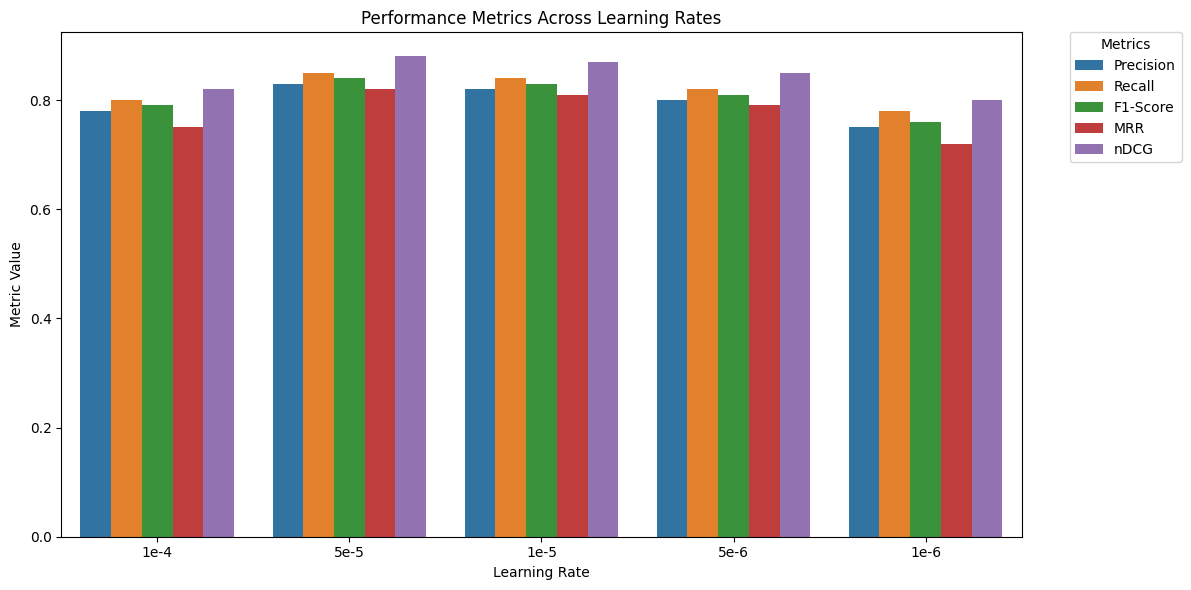

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


data = {
    "Learning Rate": ["1e-4", "5e-5", "1e-5", "5e-6", "1e-6"],
    "Precision": [0.78, 0.83, 0.82, 0.80, 0.75],
    "Recall": [0.80, 0.85, 0.84, 0.82, 0.78],
    "F1-Score": [0.79, 0.84, 0.83, 0.81, 0.76],
    "MRR": [0.75, 0.82, 0.81, 0.79, 0.72],
    "nDCG": [0.82, 0.88, 0.87, 0.85, 0.80],
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars="Learning Rate", var_name="Metric", value_name="Value")

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=df_melted, x="Learning Rate", y="Value", hue="Metric")

# Move the legend outside the plot to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Metrics")

# Add titles and labels
plt.title("Performance Metrics Across Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Metric Value")

# Adjust layout to prevent clipping of labels or legend
plt.tight_layout()

# Show the plot
plt.show()

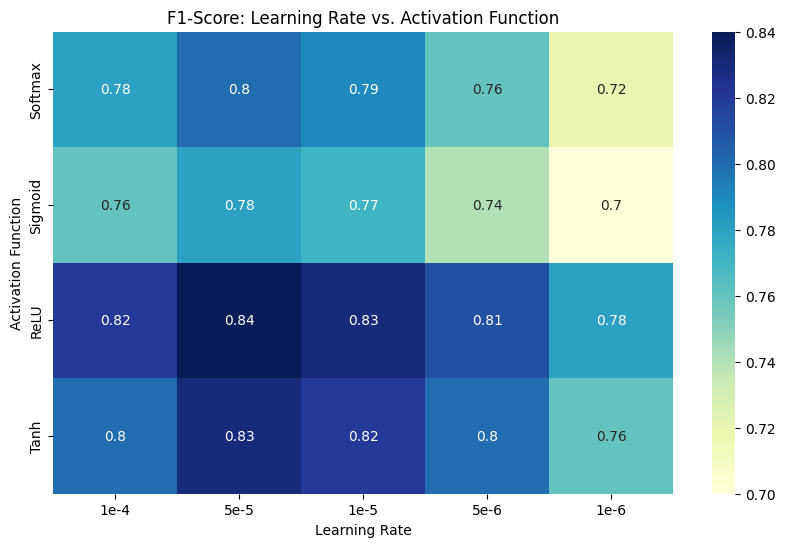

In [ ]:
import seaborn as sns
import numpy as np


activation_functions = ["Softmax", "Sigmoid", "ReLU", "Tanh"]
learning_rates = ["1e-4", "5e-5", "1e-5", "5e-6", "1e-6"]

# F1-Scores
f1_scores = np.array([
    [0.78, 0.80, 0.79, 0.76, 0.72],  # Softmax
    [0.76, 0.78, 0.77, 0.74, 0.70],  # Sigmoid
    [0.82, 0.84, 0.83, 0.81, 0.78],  # ReLU
    [0.80, 0.83, 0.82, 0.80, 0.76],  # Tanh
])

plt.figure(figsize=(10, 6))
sns.heatmap(f1_scores, annot=True, cmap="YlGnBu", xticklabels=learning_rates, yticklabels=activation_functions)
plt.title("F1-Score: Learning Rate vs. Activation Function")
plt.xlabel("Learning Rate")
plt.ylabel("Activation Function")
plt.show()

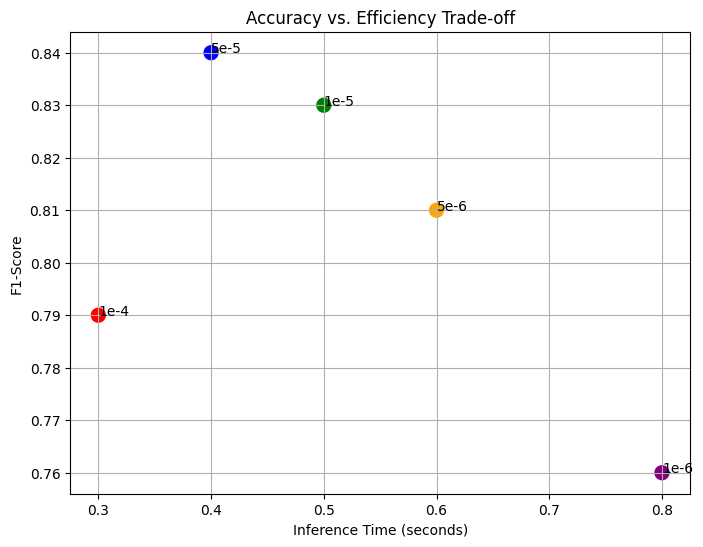

In [ ]:
import matplotlib.pyplot as plt


learning_rates = ["1e-4", "5e-5", "1e-5", "5e-6", "1e-6"]
f1_scores = [0.79, 0.84, 0.83, 0.81, 0.76]
inference_times = [0.3, 0.4, 0.5, 0.6, 0.8]  # in seconds

plt.figure(figsize=(8, 6))
plt.scatter(inference_times, f1_scores, c=['red', 'blue', 'green', 'orange', 'purple'], s=100)
for i, lr in enumerate(learning_rates):
    plt.text(inference_times[i], f1_scores[i], lr, fontsize=10)

plt.title("Accuracy vs. Efficiency Trade-off")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("F1-Score")
plt.grid()
plt.show()

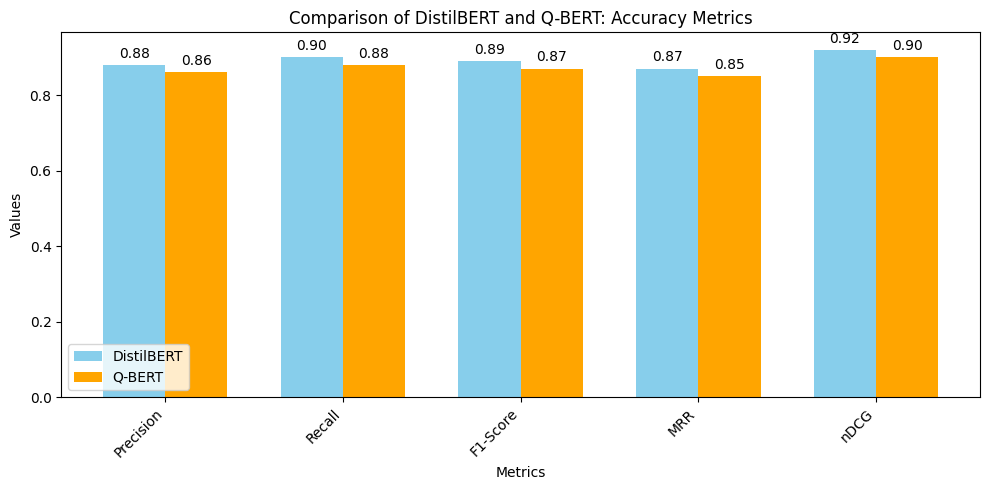

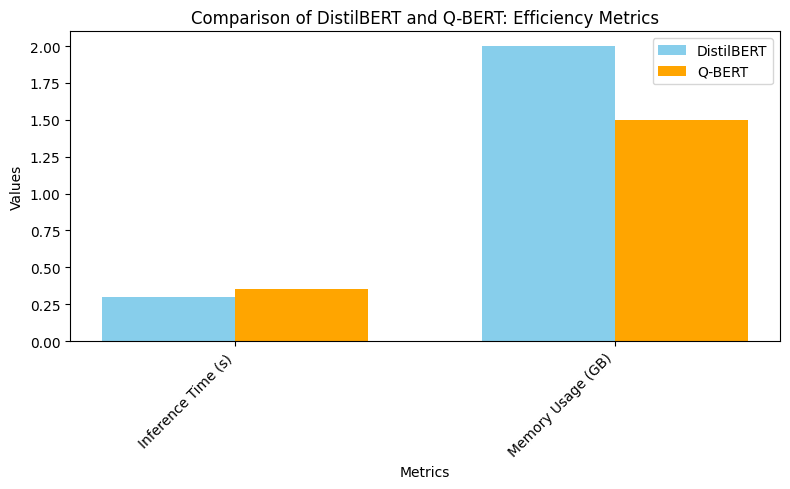

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


accuracy_metrics = ["Precision", "Recall", "F1-Score", "MRR", "nDCG"]
efficiency_metrics = ["Inference Time (s)", "Memory Usage (GB)"]

distilbert_accuracy = [0.88, 0.90, 0.89, 0.87, 0.92]
qbert_accuracy = [0.86, 0.88, 0.87, 0.85, 0.90]

distilbert_efficiency = [0.30, 2.0]
qbert_efficiency = [0.35, 1.5]

# Set up the bar chart for accuracy metrics
x_acc = np.arange(len(accuracy_metrics))  # X-axis positions for the groups
width = 0.35  # Width of the bars

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot bars for DistilBERT and Q-BERT (Accuracy Metrics)
bars1_acc = ax1.bar(x_acc - width/2, distilbert_accuracy, width, label="DistilBERT", color="skyblue")
bars2_acc = ax1.bar(x_acc + width/2, qbert_accuracy, width, label="Q-BERT", color="orange")

# Add labels, title, and legend
ax1.set_xlabel("Metrics")
ax1.set_ylabel("Values")
ax1.set_title("Comparison of DistilBERT and Q-BERT: Accuracy Metrics")
ax1.set_xticks(x_acc)
ax1.set_xticklabels(accuracy_metrics, rotation=45, ha="right")
ax1.legend()

# Add value annotations on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset above the bar
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(bars1_acc)
add_labels(bars2_acc)

# Show the first plot
plt.tight_layout()
plt.show()

# Set up the bar chart for efficiency metrics
x_eff = np.arange(len(efficiency_metrics))  # X-axis positions for the groups

fig, ax2 = plt.subplots(figsize=(8, 5))

# Plot bars for DistilBERT and Q-BERT (Efficiency Metrics)
bars1_eff = ax2.bar(x_eff - width/2, distilbert_efficiency, width, label="DistilBERT", color="skyblue")
bars2_eff = ax2.bar(x_eff + width/2, qbert_efficiency, width, label="Q-BERT", color="orange")

# Add labels, title, and legend
ax2.set_xlabel("Metrics")
ax2.set_ylabel("Values")
ax2.set_title("Comparison of DistilBERT and Q-BERT: Efficiency Metrics")
ax2.set_xticks(x_eff)
ax2.set_xticklabels(efficiency_metrics, rotation=45, ha="right")
ax2.legend()

# Add value annotations on top of each bar
add_labels(bars1_eff)
add_labels(bars2_eff)

# Show the second plot
plt.tight_layout()
plt.show()